# 2. Pre-trained CNN - VGG-16

In [5]:
import os
import cv2
import random
import shutil
import tensorflow as tf
import csv
import pandas as pd
import glob
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import h5py

# Function for evaluate model

In [2]:
def plot_loss_accurancy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def evaluate_model (model):
    y_score = model.predict(X_val_bal)
    y_pred = np.rint(y_score) # to have 0 or 1
    y_true = y_val_bal
    print("Classification report: ")
    print(metrics.classification_report(y_true,y_pred,digits = 4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # ROC curve
    fpr,tpr,th = metrics.roc_curve(y_true,y_score)
    roc_auc = metrics.roc_auc_score(y_true,y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

### Load the data

In [6]:
f = h5py.File('DataSet_Pneumonia', 'r')

X_new = f['X_train']
X_train = X_new[::]
y_new = f['y_train']
y_train = y_new[::]

X_new = f['X_test']
X_test = X_new[::]
y_new = f['y_test']
y_test = y_new[::]

X_new = f['X_val_bla']
X_val_bal = X_new[::]
y_new = f['y_val_bal']
y_val_bal = y_new[::]

In [7]:
BATCH_SIZE = 32 #this is default in keras, so it's no need to package
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

### Import pre-trained VGG16 model from keras

In [8]:
from tensorflow.keras.applications import VGG16

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 14714688


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [13]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [14]:
inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                             

Only the weights from the two added Dense layers will be trained.

In [16]:
dir_name = "/Users/marysia/A_DL_Project"

if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'pneumonia_pretrained.h5')

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [17]:
save_path

'/Users/marysia/A_DL_Project/pneumonia_pretrained.h5'

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=30, # 50 epochs take approximately 15 minutes
    validation_data=(X_test, y_test),
    callbacks = callbacks_list
)

Epoch 1/30


2023-01-27 11:03:27.916472: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


129/129 [==============================] - ETA: 0s - loss: 36.5286 - accuracy: 0.8729
Epoch 1: val_loss improved from inf to 12.71400, saving model to /Users/marysia/A_DL_Project/pneumonia_pretrained.h5
129/129 [==============================] - 709s 5s/step - loss: 36.5286 - accuracy: 0.8729 - val_loss: 12.7140 - val_accuracy: 0.9477
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 15.8646 - accuracy: 0.9280
Epoch 2: val_loss did not improve from 12.71400
129/129 [==============================] - 710s 6s/step - loss: 15.8646 - accuracy: 0.9280 - val_loss: 17.8470 - val_accuracy: 0.9306
Epoch 3/30
129/129 [==============================] - ETA: 0s - loss: 11.5697 - accuracy: 0.9344
Epoch 3: val_loss improved from 12.71400 to 8.89431, saving model to /Users/marysia/A_DL_Project/pneumonia_pretrained.h5
129/129 [==============================] - 735s 6s/step - loss: 11.5697 - accuracy: 0.9344 - val_loss: 8.8943 - val_accuracy: 0.9556
Epoch 4/30
129/129 [=============

Epoch 21/30
129/129 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.9534
Epoch 21: val_loss did not improve from 1.05429
129/129 [==============================] - 714s 6s/step - loss: 1.4772 - accuracy: 0.9534 - val_loss: 3.0493 - val_accuracy: 0.9295
Epoch 22/30
129/129 [==============================] - ETA: 0s - loss: 1.3552 - accuracy: 0.9561
Epoch 22: val_loss did not improve from 1.05429
129/129 [==============================] - 856s 7s/step - loss: 1.3552 - accuracy: 0.9561 - val_loss: 1.4741 - val_accuracy: 0.9579
Epoch 23/30
129/129 [==============================] - ETA: 0s - loss: 1.3813 - accuracy: 0.9549
Epoch 23: val_loss did not improve from 1.05429
129/129 [==============================] - 951s 7s/step - loss: 1.3813 - accuracy: 0.9549 - val_loss: 4.2178 - val_accuracy: 0.8987
Epoch 24/30
129/129 [==============================] - ETA: 0s - loss: 1.2556 - accuracy: 0.9546
Epoch 24: val_loss did not improve from 1.05429
129/129 [===============

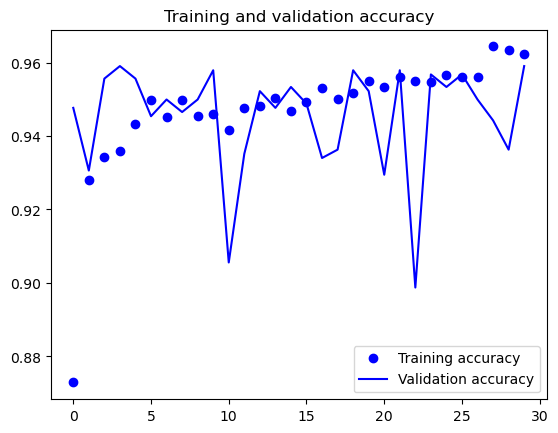

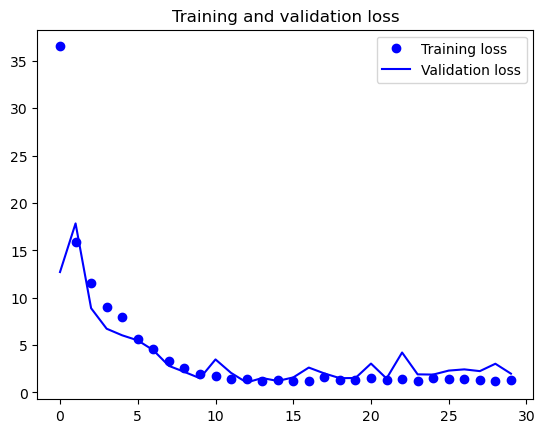

In [19]:
plot_loss_accurancy(history)

# Fine tuning

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Only the last 3 convolutional layers will be fine-tuned.

In [26]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [28]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor="val_loss",
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=30, # 30 epochs take approximately 10 minutes
    validation_data=(X_test, y_test),
    callbacks=callbacks_list)

Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 1.5481 - accuracy: 0.9471
Epoch 1: val_loss improved from inf to 1.42485, saving model to /Users/marysia/A_DL_Project/pneumonia_pretrained.h5
129/129 [==============================] - 746s 6s/step - loss: 1.5481 - accuracy: 0.9471 - val_loss: 1.4248 - val_accuracy: 0.9329
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.9432
Epoch 2: val_loss improved from 1.42485 to 0.93215, saving model to /Users/marysia/A_DL_Project/pneumonia_pretrained.h5
129/129 [==============================] - 814s 6s/step - loss: 0.6792 - accuracy: 0.9432 - val_loss: 0.9322 - val_accuracy: 0.9295
Epoch 3/30
129/129 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.9466
Epoch 3: val_loss improved from 0.93215 to 0.59161, saving model to /Users/marysia/A_DL_Project/pneumonia_pretrained.h5
129/129 [==============================] - 1051s 8s/step - loss: 0.3688 - accuracy: 0.9466 -

Epoch 19/30
129/129 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9861
Epoch 19: val_loss did not improve from 0.12658
129/129 [==============================] - 936s 7s/step - loss: 0.0487 - accuracy: 0.9861 - val_loss: 0.1293 - val_accuracy: 0.9670
Epoch 20/30
129/129 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9883
Epoch 20: val_loss did not improve from 0.12658
129/129 [==============================] - 913s 7s/step - loss: 0.0341 - accuracy: 0.9883 - val_loss: 0.1799 - val_accuracy: 0.9613
Epoch 21/30
129/129 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.9885
Epoch 21: val_loss did not improve from 0.12658
129/129 [==============================] - 1061s 8s/step - loss: 0.0355 - accuracy: 0.9885 - val_loss: 0.4229 - val_accuracy: 0.9147
Epoch 22/30
129/129 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9859
Epoch 22: val_loss did not improve from 0.12658
129/129 [==============

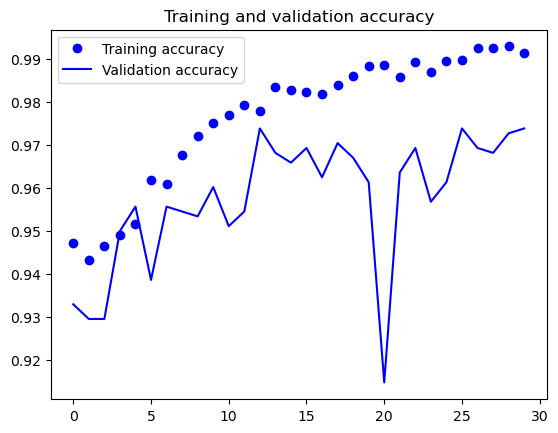

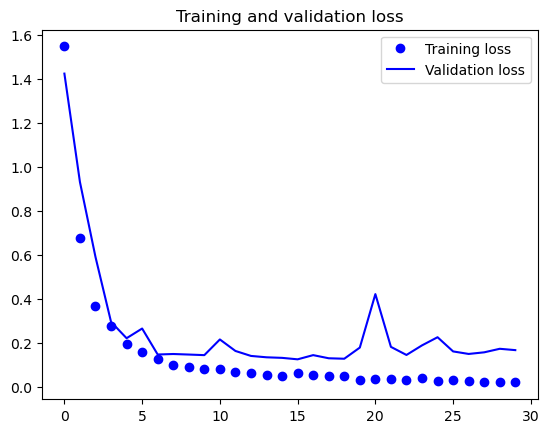

In [29]:
plot_loss_accurancy(history)

In [30]:
dir_name = "/Users/marysia/Desktop/Deep learning/pre_trained_model"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'pneumonia_models'))

INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/pre_trained_model/pneumonia_models/assets


INFO:tensorflow:Assets written to: /Users/marysia/Desktop/Deep learning/pre_trained_model/pneumonia_models/assets


15/15 [==============================] - 54s 4s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9652    0.9328    0.9487       238
           1     0.9350    0.9664    0.9504       238

    accuracy                         0.9496       476
   macro avg     0.9501    0.9496    0.9496       476
weighted avg     0.9501    0.9496    0.9496       476



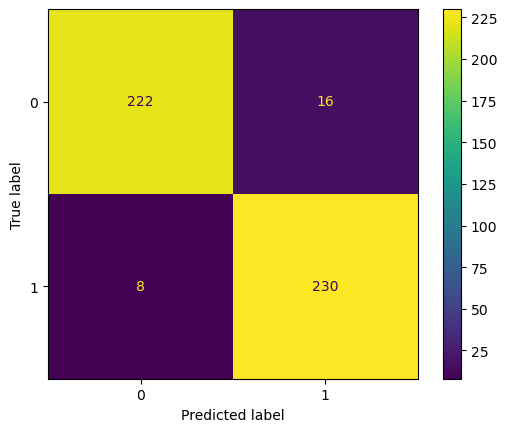

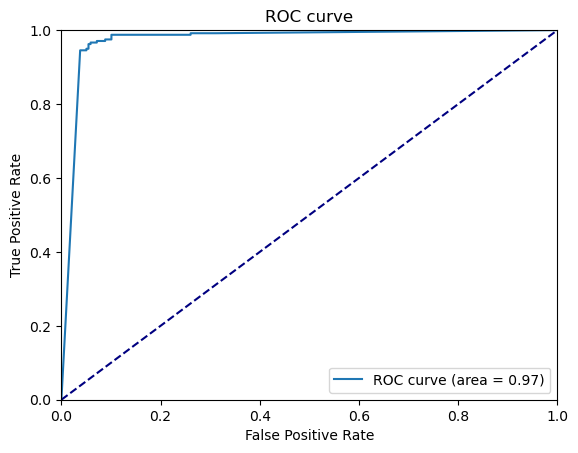

In [22]:
evaluate_model(model)

In [31]:
y_score_vgg = model.predict(X_val_bal)
y_pred_vgg = np.rint(y_score_vgg)

15/15 [==============================] - 72s 5s/step


In [33]:
"""Save prediction"""

import h5py

with h5py.File('Prediction', 'w') as f:
    dset = f.create_dataset("y_pred_vgg", data=y_pred_vgg)
